In [1]:
import sys
sys.path.append("../../Chapter_3")

from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sbn
from umap import UMAP

from Bio import SeqIO

from Utils.negative_sampling import IterableProteinEmbedding
from Utils.train import BlockInputShapeReformatter

/home/bobby/.local/lib/python3.8/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  numba.core.entrypoints.init_all()


In [2]:
import re

def isolate_patient_id_number(complete_id : str) -> int:
    if '-' in complete_id:
        return int(re.sub('[AB]0+(\d+)-.*',r'\1', complete_id))
    else:
        return int(re.sub('[AB]0+(\d+)',r'\1', complete_id))

In [3]:
# CARES summary stats (relevant subset of "DrexelMedCARESCohort_DATA_LABELS_2017-12-06_1414.csv")
cares_metadata = pd.read_csv("../Data/PatientMetadata/All_Cares_Summary_Stats.csv", index_col = 0)
cares_metadata.index = [isolate_patient_id_number(patient_label) for patient_label in cares_metadata.index]

# Patient neuro metadata?
neuro = pd.read_csv("../Data/PatientMetadata/DD_neuro_2021_06_14-05_scaled.csv", index_col = 0)
fullneuro = pd.read_csv("../Data/PatientMetadata/fullneuro_2021-09-04.csv", index_col = 0)

In [4]:
with open("../Data/CohortTats/Sanger/Sanger_Unambiguous_Trimmed_Normal_Tats.fasta") as handle:
    sanger_tats = {record.id : " ".join(list(str(record.seq))) for record in SeqIO.parse(handle, 'fasta') }

with open("../Data/CohortTats/PacBio/PacBio_Trimmed_Normal_Tats.fasta") as handle:
    # if neuro['study_id'].isin([isolate_patient_id_number(record.id.split('_')[0])]).any()
    pacbio_tats = {record.id.split('_')[0] : " ".join(list(str(record.seq))) for record in SeqIO.parse(handle, 'fasta') }

sanger_tats.update(pacbio_tats)
cares_tats = sanger_tats

cares_only_id_tats = {isolate_patient_id_number(participant) : seq for participant, seq in cares_tats.items()}
cares_tat_seqs = list(cares_tats.values())

In [5]:
cares_only_id_tats

{382: 'M E P V D P R L E P W K H P G S Q P K T P C T N C Y C K K C C F H C Q V C F I T K G L G I S Y G R K K R R Q R R R P P Q G S Q T H Q V S L S K Q P A S Q A R K D P T G P K E S K K K V K R E T E A D P V D',
 8: 'M E P V D P R L E P W K H P G S Q P K T A C N T C Y C K K C C L H C Q V C F I T K G L G I S Y G R K K R R Q R R R A S Q D S E T R Q V P L S K Q S A P Q R R G D P T G P K E S K K K V E R E T E T D P V H',
 95: 'M E P V D P R L E P W N H P G S Q P K T P C T P C Y C K R C C L H C Q V C F I T K G L G I S Y G R K K R R K R R R S P Q D S E T H Q G P L S K Q P T S Q P R G D P T G P E K S K K K V E R E T E T H P R D',
 26: 'M E P V D P R L E P W K H P G S Q P K T P C T N C Y C K K C C F H C Q K C F T T K G L G I S Y G R K K R R Q R R R A D Q D S Q T H Q V S L S K Q P A S Q P G G N P T G P K E',
 198: 'M E P V D P R L E P W K H P G S Q P R T A C S S C Y C K K C C L H C Q V C F M K K G L G I S Y G R K K R R Q R R R P P Q D S E D H Q G A L S E Q P A S Q P R G D P T G P K E S K K K V E

In [6]:
# For patient that have a linked Tat sequence, here is their described metadata
cares_metadata[ cares_metadata.index.isin(cares_only_id_tats.keys()) ].describe().round(2)

,Age,Race (black),Years Seropositive,Nadir CD4,Current CD4,Current CD8,Peak log viral load,Current log viral load,TMHDS,HAART (on),Gender (Male),Drug use (any)
count,163.00,163.0,143.00,139.00,159.00,145.00,130.00,158.00,154.00,163.00,163.00,163.00
mean,52.61,0.9,13.14,232.45,629.38,1005.03,4.35,1.86,8.73,0.94,0.63,0.31
std,8.38,0.3,6.40,155.38,401.36,717.59,1.27,0.96,2.87,0.24,0.49,0.46
min,22.00,0.0,0.00,0.00,20.00,236.00,1.68,1.30,2.00,0.00,0.00,0.00
25%,47.50,1.0,10.00,123.50,374.50,606.00,3.50,1.30,7.00,1.00,0.00,0.00
50%,53.00,1.0,12.00,224.00,591.00,874.00,4.60,1.30,9.00,1.00,1.00,0.00
75%,58.00,1.0,17.00,326.00,812.50,1222.00,5.15,2.07,11.00,1.00,1.00,1.00
max,73.00,1.0,31.00,736.00,3269.00,7286.00,10.00,5.20,12.00,1.00,1.00,1.00


In [7]:
#cares_only_id_tats

In [8]:
patient_ids = cares_only_id_tats.keys()

filtered_neuro_metadata = neuro[ neuro.index.isin(patient_ids) ]

neuro_tats = {key : value for key,value in cares_only_id_tats.items() if key in filtered_neuro_metadata.index}

neuro_tat_seqs = list(neuro_tats.values())

neuro_tats_patient_ids = [key for key in cares_only_id_tats.keys() if key in filtered_neuro_metadata.index]

filtered_neuro_metadata = filtered_neuro_metadata.loc[neuro_tats.keys(),:]

filtered_neuro_metadata

,date_of_visit,age,cnns_hdiscrim_t,cnns_hretain_t,cnns_hvlt4_t,cnns_hvlt_t,hvlt1intr,hvlt1pers,hvlt2pers,hvlt_delay,...,bnt30_plc,cnns_swords_z,cnns_anwords_z,cnns_bnt30_z,language_domain_z,language_domain_deficit,race_desc,global_score_z,gds,impaired
study_id,,,,,,,,,,,,,,,,,,,,,
26,2021-04-28,61.0,35.0,43.0,35.0,31.0,0.0,1.0,0.0,4.0,...,29.0,-1.1,-1.2,1.1,-0.100000,0.0,AA,-0.601586,0.250,0.0
13,2021-02-25,75.0,38.0,64.0,49.0,29.0,1.0,0.0,1.0,6.0,...,29.0,-1.5,-0.5,1.9,0.400000,0.0,AA,-0.790278,0.625,1.0
44,2021-04-14,56.0,22.0,39.0,34.0,26.0,1.0,0.0,2.0,3.0,...,29.0,-1.5,-2.1,0.9,-0.766667,0.0,AA,-1.331508,1.375,1.0
25,2021-03-16,63.0,36.0,51.0,41.0,40.0,0.0,1.0,0.0,5.0,...,25.0,-1.3,1.0,-0.8,-0.300000,0.0,AA,-0.892701,0.375,0.0
211,2021-01-13,52.0,50.0,39.0,38.0,49.0,0.0,1.0,0.0,5.0,...,25.0,0.4,1.1,-1.1,0.333333,0.0,AA,-0.692866,0.375,0.0
109,2021-04-15,52.0,66.0,60.0,57.0,56.0,0.0,0.0,1.0,10.0,...,30.0,2.4,2.0,1.6,2.266667,0.0,AA,1.034316,0.000,0.0
2,2021-03-11,70.0,27.0,39.0,42.0,35.0,0.0,0.0,0.0,3.0,...,27.0,-0.6,0.2,0.5,0.300000,0.0,AA,-0.910417,1.250,1.0
195,2021-04-07,57.0,32.0,31.0,27.0,30.0,0.0,0.0,1.0,1.0,...,30.0,-1.7,-0.5,1.8,0.333333,0.0,AA,-0.748553,0.750,1.0
5,2020-11-19,61.0,25.0,62.0,43.0,40.0,0.0,0.0,0.0,5.0,...,30.0,0.1,1.3,2.3,1.333333,0.0,AA,-0.293763,0.250,0.0


In [9]:
# Filer and organize metadata so that encoded Tat seqs and metadata are in same order
filtered_cares_metadata = cares_metadata[ cares_metadata.index.isin(patient_ids) ]
filtered_cares_metadata = filtered_cares_metadata.loc[patient_ids,:]

filtered_cares_metadata.describe()

,Age,Race (black),Years Seropositive,Nadir CD4,Current CD4,Current CD8,Peak log viral load,Current log viral load,TMHDS,HAART (on),Gender (Male),Drug use (any)
count,163.000000,163.000000,143.000000,139.000000,159.000000,145.000000,130.000000,158.000000,154.000000,163.00000,163.000000,163.000000
mean,52.607362,0.901840,13.139860,232.453237,629.377358,1005.027586,4.352154,1.856976,8.733766,0.93865,0.625767,0.306748
std,8.376507,0.298447,6.402686,155.378557,401.360245,717.593557,1.265524,0.963966,2.872093,0.24071,0.485416,0.462565
min,22.000000,0.000000,0.000000,0.000000,20.000000,236.000000,1.681241,1.301030,2.000000,0.00000,0.000000,0.000000
25%,47.500000,1.000000,10.000000,123.500000,374.500000,606.000000,3.499629,1.301030,7.000000,1.00000,0.000000,0.000000
50%,53.000000,1.000000,12.000000,224.000000,591.000000,874.000000,4.598921,1.301030,9.000000,1.00000,1.000000,0.000000
75%,58.000000,1.000000,17.000000,326.000000,812.500000,1222.000000,5.152186,2.072805,11.000000,1.00000,1.000000,1.000000
max,73.000000,1.000000,31.000000,736.000000,3269.000000,7286.000000,10.000003,5.203577,12.000000,1.00000,1.000000,1.000000


In [10]:
patient_order = pd.Series(cares_only_id_tats.keys())

In [11]:
model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

tat_embedder = IterableProteinEmbedding(list(cares_only_id_tats.values()), tokenizer, model, chunksize = 3, max_len = 110, cuda = True)
#neuro_tat_embedder = IterableProteinEmbedding(neuro_tat_seqs, tokenizer, model, chunksize = 3, max_len = 110, cuda = True)

embedded_cares_tat_seqs = torch.cat(list(tat_embedder)).cpu()
#embedded_neuro_tat_seqs = torch.cat(list(neuro_tat_embedder)).cpu()

  0%|          | 0/55 [00:00<?, ?it/s]

In [12]:
protbert_transformed_umap = UMAP(random_state = 255).fit(embedded_cares_tat_seqs)

reduced_protbert_cares_tat_seqs = protbert_transformed_umap.transform(embedded_cares_tat_seqs)
#reduced_protbert_neuro_tat_seqs = protbert_transformed_umap.transform(embedded_neuro_tat_seqs)

In [13]:
shape_reformatter = BlockInputShapeReformatter()
BLOCKNAME = "StackedRes"

embedded_cares_tat_seqs = shape_reformatter.reformat_input(BLOCKNAME, embedded_cares_tat_seqs)
# embedded_neuro_tat_seqs = shape_reformatter.reformat_input(BLOCKNAME, embedded_neuro_tat_seqs)

In [14]:
model = torch.load("../Models/NonRefinedMainModel.torch").cpu()
model.eval()

protein_block = model.blocks.prot

In [15]:
prot_block_embedded_cares_tat_seqs = nn.Flatten()(*[block(embedded_cares_tat_seqs) for block in protein_block]).cpu().detach()
#prot_block_embedded_neuro_tat_seqs = nn.Flatten()(*[block(embedded_neuro_tat_seqs) for block in protein_block]).cpu().detach()

In [16]:
prot_block_embedded_cares_tat_seqs

tensor([[0.0738, 0.0000, 1.1902,  ..., 0.6668, 0.1384, 0.0000],
        [0.0739, 0.0000, 1.1348,  ..., 1.1480, 0.2602, 0.0000],
        [0.1686, 0.3740, 1.0748,  ..., 1.5355, 0.7303, 0.0000],
        ...,
        [0.1717, 0.0000, 0.9681,  ..., 1.7671, 0.4293, 0.0000],
        [0.0000, 0.0000, 1.3749,  ..., 1.0458, 0.1335, 0.0000],
        [0.0000, 0.0000, 1.3347,  ..., 1.1723, 0.0786, 0.0000]])

In [17]:
model_transformed_umap = UMAP(random_state = 255).fit(prot_block_embedded_cares_tat_seqs)

reduced_model_cares_tat_seqs = model_transformed_umap.transform(prot_block_embedded_cares_tat_seqs)
#reduced_model_neuro_tat_seqs = model_transformed_umap.transform(prot_block_embedded_neuro_tat_seqs)

In [18]:
def plot_umap_out(umap_out, ax, **kwargs):
    g = sbn.scatterplot(x = umap_out[:,0], y = umap_out[:,1], ax = ax, **kwargs) 
    
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2");
    
    return g

In [19]:
from matplotlib.colors import Normalize

def plot_cbar(cmap, ax, vmin=None, vmax=None, midpoint=None, clip=False, **cbar_kwargs):
    if type(midpoint) in [int,float]:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=MidpointNormalize(vmin = vmin, midpoint = midpoint, vmax = vmax))
    else:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin = vmin, vmax = vmax))
        
    sm.set_array([])
    ax.figure.colorbar(sm, ax = ax, **cbar_kwargs)

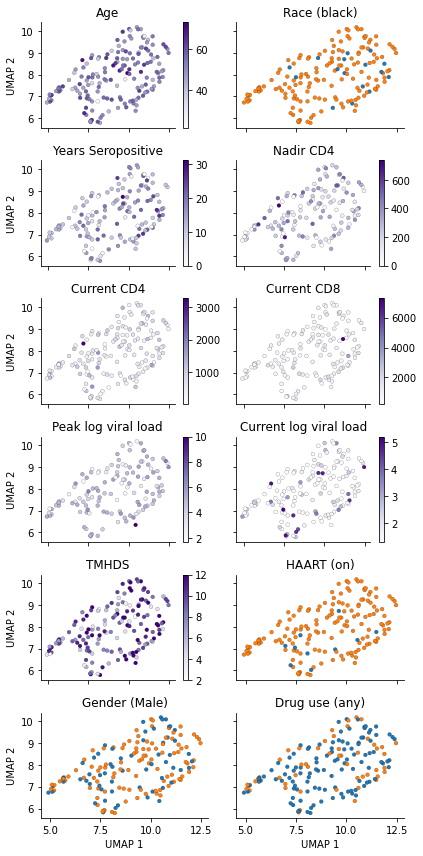

In [20]:
################################################
# RPI model pass
################################################

fig,axes = plt.subplots(6,2,figsize=(6,12), sharey = True, sharex = True)

SIZE = 15
LINEWIDTH = 0.15

i = -1
for n in range(12):
    
    if n % 2 == 0:
        i += 1    
    j = n%2
    
    hue = filtered_cares_metadata.iloc[:,n]
    
    if len(filtered_cares_metadata.iloc[:,n].unique()) > 2:
        
        plot_umap_out(reduced_protbert_cares_tat_seqs, axes[i,j], s = SIZE, hue = hue, 
                          palette = "Purples", edgecolor = 'k', linewidth = LINEWIDTH, legend = False)
            
        plot_cbar(cmap = "Purples", ax = axes[i,j], vmin = hue.min(), vmax = hue.max())
        
    else:
        g = plot_umap_out(reduced_protbert_cares_tat_seqs, axes[i,j], s = SIZE, hue = hue, 
                      edgecolor = 'k', linewidth = LINEWIDTH, legend = False)
        
        #g.legend(loc='lower right', bbox_to_anchor=(1.25, 0.5), ncol=1)
        
    axes[i,j].set_title(filtered_cares_metadata.columns[n])

# Blue is always false, orange is always true, make the legends in PP
plt.tight_layout()
sbn.despine()

plt.savefig("ProtBERT_reduced_metadata_embedding.png", dpi = 300)

In [21]:
########################################################
#
########################################################

patient_neuro_tested = patient_order.isin(neuro.index)
tat_seq_order = neuro.index.isin(patient_order)
proper_neuro_order = patient_order[patient_neuro_tested]

reordered_neuro = neuro.loc[proper_neuro_order, :]

neuro_tat_coords = reduced_protbert_cares_tat_seqs[patient_neuro_tested]
model_neuro_tat_coords = reduced_model_cares_tat_seqs[patient_neuro_tested]

In [22]:
import matplotlib.colors as colors
import numpy as np

class MidpointNormalize(colors.Normalize):
    """
    From Joe Kington: This one gives two different linear ramps:
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [23]:
#coord_domains.min()
#coord_domains.max()
# "vlag"

def plot_neuro_domain(reordered_neuro, neuro_tat_coords, domain, ax, palette = 'vlag', scatter_kwargs = dict(), cbar_kwargs = dict()) -> None:
    
    coord_domains = reordered_neuro[domain]
    
    plot_cbar(palette, ax, vmin = coord_domains.min(), midpoint = 0, vmax = coord_domains.max(), **cbar_kwargs)
    
    plot_umap_out(neuro_tat_coords, ax, hue = coord_domains, palette = palette, edgecolor = 'k', 
                  hue_norm = MidpointNormalize(vmin = coord_domains.min(), midpoint = 0, vmax = coord_domains.max()),
                  legend = False, **scatter_kwargs)
    


In [24]:
DOMAIN_TESTS = ['groovedpegdom_heaton_z', 'groovedpegnondom_heaton_z', 
                'traila_heaton_z','trailb_heaton_z', 
                'categoryfluency_total_heaton_z','letterfluencyfas_total_heaton_z', 
                'cnns_reyo_z',
                'bvmt_immediate_heaton_z','bvmt_delay_heaton_z']

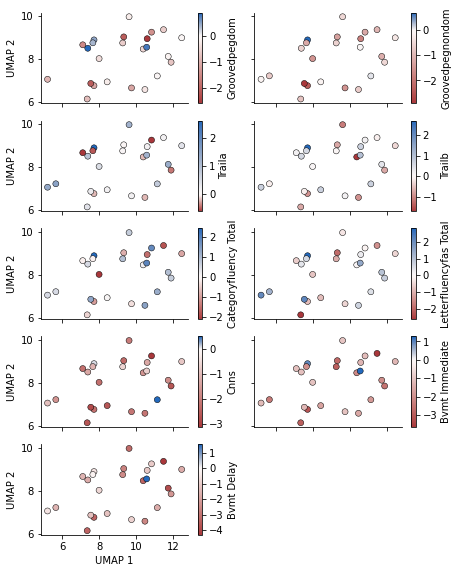

In [25]:
fig,axes = plt.subplots(5,2, figsize = (6.5,8), sharey = True, sharex = True)
#plot_umap_out(reduced_protbert_cares_tat_seqs, ax, color = 'gray', alpha = 0.2)

PALETTE = "vlag_r"
#domains = [col for col in neuro.columns if 'domain_z' in col]

i = -1
for n,test in enumerate(DOMAIN_TESTS):
    
    if n % 2 == 0:
        i += 1    
    j = n%2
    
    plot_neuro_domain(reordered_neuro, neuro_tat_coords, domain = test, ax = axes[i,j], 
                      cbar_kwargs = {"label" : " ".join(test.split("_")[:-2]).title(), 'ticks': range(-5,6)}, 
                      #scatter_kwargs = {"s" : 15},
                      palette = PALETTE)

plt.tight_layout()
sbn.despine()

axes[-1,-1].set_visible(False)

plt.savefig("ProtBERT_reduced_neuro_domain_embedding.png", dpi = 300)

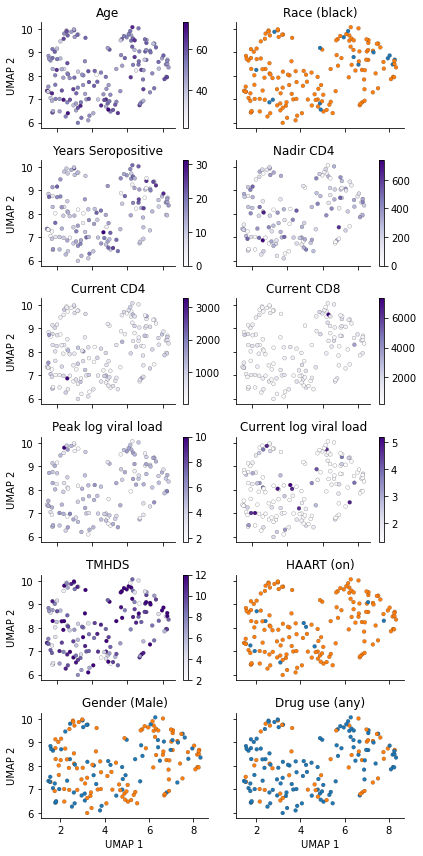

In [26]:
fig,axes = plt.subplots(6,2,figsize=(6,12), sharex = True, sharey = True)

SIZE = 15
LINEWIDTH = 0.15

i = -1
for n in range(12):
    
    if n % 2 == 0:
        i += 1    
    j = n%2
    
    hue = filtered_cares_metadata.iloc[:,n]
    
    if len(filtered_cares_metadata.iloc[:,n].unique()) > 2:
        
        plot_umap_out(reduced_model_cares_tat_seqs, axes[i,j], s = SIZE, hue = hue, 
                      palette = "Purples", edgecolor = 'k', linewidth = LINEWIDTH, legend = False)
            
        plot_cbar(cmap = "Purples", ax = axes[i,j], vmin = hue.min(), vmax = hue.max())
        
    else:
        g = plot_umap_out(reduced_model_cares_tat_seqs, axes[i,j], s = SIZE, hue = hue, 
                      edgecolor = 'k', linewidth = LINEWIDTH, legend = False)
        
        #g.legend(loc='lower right', bbox_to_anchor=(1.25, 0.5), ncol=1)
        
    axes[i,j].set_title(filtered_cares_metadata.columns[n])
    
#     plot_umap_out(reduced_model_cares_tat_seqs, axes[i,j], s = SIZE, hue = filtered_cares_metadata.iloc[:,x], 
#                   palette = "Purples", edgecolor = 'k', linewidth = LINEWIDTH, legend = False)
    
#     axes[i,j].set_title(filtered_cares_metadata.columns[x])
    
plt.tight_layout()
sbn.despine()

plt.savefig("RPI_model_reduced_metadata_embedding.png", dpi = 300)

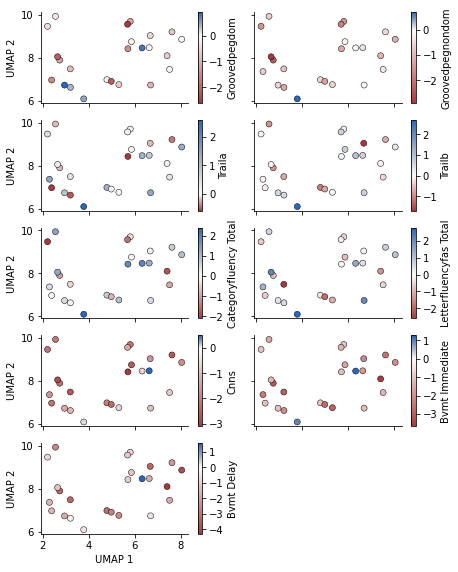

In [27]:
fig,axes = plt.subplots(5,2, figsize = (6.5,8), sharey = True, sharex = True)

PALETTE = "vlag_r"

#domains = [col for col in neuro.columns if 'domain_z' in col]


i = -1
for n,test in enumerate(DOMAIN_TESTS):
    
    if n % 2 == 0:
        i += 1    
    j = n%2
    
    plot_neuro_domain(reordered_neuro, model_neuro_tat_coords, domain = test, ax = axes[i,j], 
                      cbar_kwargs = {"label" : " ".join(test.split("_")[:-2]).title(), 'ticks': range(-5,6)}, 
                      palette = PALETTE)
plt.tight_layout()
sbn.despine()

axes[-1,-1].set_visible(False)

plt.savefig("RPI_model_reduced_neuro_domain_embedding.png", dpi = 300)